# A CNN Mnist Model

In [ ]:
%install '.package(path: "$cwd/FastaiNotebook_05b_early_stopping")' FastaiNotebook_05b_early_stopping

Installing packages:
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/FastaiNotebook_05b_early_stopping")
		FastaiNotebook_05b_early_stopping
With SwiftPM flags: []
Working in: /tmp/tmpkeqsbr2k/swift-install
Fetching https://github.com/mxcl/Path.swift
Fetching https://github.com/JustHTTP/Just
Completed resolution in 2.97s
Cloning https://github.com/JustHTTP/Just
Resolving https://github.com/JustHTTP/Just at 0.7.1
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.2
Compile Swift Module 'Just' (1 sources)
Compile Swift Module 'Path' (9 sources)
Compile Swift Module 'FastaiNotebook_05b_early_stopping' (9 sources)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Linking ./.build/x86_64-unknown-linux/debug/libjupyterInstalledPackages.so
Initializing Swift...
Installation complete!


## Load data

In [ ]:
import FastaiNotebook_05b_early_stopping
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [ ]:
// export
import Path
import TensorFlow
import Python

In [ ]:
let plt = Python.import("matplotlib.pyplot")

In [ ]:
let data = mnistDataBunch(flat: false, bs: 512)

In [ ]:
let firstBatch = data.train.ds.first(where: { _ in true })!
let batchShape = firstBatch.xb.shape
let batchSize = batchShape.dimensions[0]
let exampleSideSize = batchShape.dimensions[1]
assert(exampleSideSize == batchShape.dimensions[2])
print("Batch size: \(batchSize)")
print("Example side size: \(exampleSideSize)")

let classCount = firstBatch.yb.shape.dimensions[0]
print("Class count: \(classCount)")

Batch size: 512
Example side size: 28
Class count: 512


In [ ]:
firstBatch.xb.shape

▿ TensorShape
  ▿ dimensions : 3 elements
    - 0 : 512
    - 1 : 28
    - 2 : 28


In [ ]:
// export
extension Learner {
    public class AddChannel: Delegate {
        public override func batchWillStart(learner: Learner) {
            learner.currentInput = learner.currentInput!.expandingShape(at: -1)
        }
    }
    
    public func makeAddChannel() -> AddChannel { return AddChannel() }
}

In [ ]:
//export
extension Array: Layer where Element: Layer, Element.Input == Element.Output {
    public typealias Input = Element.Input
    public typealias Output = Element.Output
    
    @differentiable(vjp: _vjpApplied)
    public func call(_ input: Input) -> Output {
        var activation = input
        for layer in self {
            activation = layer(activation)
        }
        return activation
    }
    
    public func _vjpApplied(_ input: Input)
        -> (Output, (Output.CotangentVector) -> (Array.CotangentVector, Input.CotangentVector))
    {
        var activation = input
        var pullbacks: [(Input.CotangentVector) -> (Element.CotangentVector, Input.CotangentVector)] = []
        for layer in self {
            let (newActivation, newPullback) = layer.valueWithPullback(at: activation) { $0($1) }
            activation = newActivation
            pullbacks.append(newPullback)
        }
        func pullback(_ v: Input.CotangentVector) -> (Array.CotangentVector, Input.CotangentVector) {
            var activationGradient = v
            var layerGradients: [Element.CotangentVector] = []
            for pullback in pullbacks.reversed() {
                let (newLayerGradient, newActivationGradient) = pullback(activationGradient)
                activationGradient = newActivationGradient
                layerGradients.append(newLayerGradient)
            }
            return (Array.CotangentVector(layerGradients.reversed()), activationGradient)
        }
        return (activation, pullback)
    }
}

In [ ]:
//export 
public func conv<Scalar>(_ cIn: Int, _ cOut: Int, ks: Int = 3, stride: Int = 2) -> FAConv2D<Scalar> {
    return FAConv2D<Scalar>(filterShape: (ks, ks, cIn, cOut), 
                            strides: (stride,stride), 
                            padding: .same, 
                            activation: relu)
}

public struct CnnModel: Layer {
    public var convs: [FAConv2D<Float>]
    public var pool = FAAdaptiveAvgPool2D<Float>()
    public var flatten = Flatten<Float>()
    public var linear: FADense<Float>
    
    public init(channelIn: Int, nOut: Int, filters: [Int]){
        convs = []
        let allFilters = [channelIn] + filters
        for i in 0..<filters.count { convs.append(conv(allFilters[i], allFilters[i+1])) }
        linear = FADense<Float>(inputSize: filters.last!, outputSize: nOut)
    }
    
    @differentiable
    public func call(_ input: TF) -> TF {
        return input.sequenced(through: convs, pool, flatten, linear)
    }
}

In [ ]:
let model = CnnModel(channelIn: 1, nOut: 10, filters: [8, 16, 32, 32])

In [ ]:
// Test that data goes through the model as expected.
let predictions = model(firstBatch.xb.expandingShape(at: -1))
print(predictions.shape)
print(predictions[0])

TensorShape(dimensions: [512, 10])
[ 0.0050012795,  -0.014207464, -0.0001784563,  -0.014150087, -0.0052272202,    0.03503478,
   0.016656812, -0.0026444346,  -0.024077296,   0.026180496]


# Compare training on CPU and GPU

In [ ]:
func optFunc(_ model: CnnModel) -> SGD<CnnModel> { return SGD(for: model, learningRate: 0.4)}
func modelInit() -> CnnModel { return CnnModel(channelIn: 1, nOut: 10, filters: [8, 16, 32, 32]) }
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegates([learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std),
                      learner.makeAddChannel()])

In [ ]:
// This happens on the GPU (if you have one and it's configured correctly).
// I tried this on a GCE 8vCPU 30GB + Tesla P100:
// - time: ~4.3s
// - nvidia-smi shows ~10% GPU-Util while this is running
time { try! learner.fit(1) }

Epoch 0: [0.56210345, 0.8226]                                                   
4158.049943 ms                                                                


In [ ]:
// This happens on the CPU.
// I tried this on a GCE 8vCPU 30GB + Tesla P100:
// - time: ~6.3s
// - nvidia-smi shows 0% GPU-Util while this is running
time {
    withDevice(.cpu) { try! learner.fit(1) }
}

Epoch 0: [0.15199311, 0.9556]                                                   
6095.351979 ms                                                                


# Collect Layer Activation Statistics

In [ ]:
class ActivationStatistics: LayerDelegate<Tensor<Float>> {
    var activationMeans: [Float] = []
    var activationStds: [Float] = []    
    override func didProduceActivation(_ activation: Tensor<Float>) {
        activationMeans.append(activation.mean().scalar!)
        activationStds.append(activation.standardDeviation().reshaped(to: []).scalar!)
    }
}

In [ ]:
extension KeyPathIterable {    
    mutating func initializeLayerDelegates<T>(with initializer: () -> LayerDelegate<T>) {
        for kp in recursivelyAllWritableKeyPaths(to: LayerDelegate<T>.self) {
            self[keyPath: kp] = initializer()
        }
    }
    
    func layerDelegates<T, D: LayerDelegate<T>>(havingType: D.Type) -> [D] {
        var result: [D] = []
        for kp in recursivelyAllWritableKeyPaths(to: LayerDelegate<T>.self) {
            guard let d = self[keyPath: kp] as? D else { continue }
            result.append(d)
        }
        return result
    }
}

In [ ]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegates([learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std),
                      learner.makeAddChannel()])

learner.model.initializeLayerDelegates(with: { ActivationStatistics() })

In [ ]:
// This LayerDelegate stuff slows it down to ~6s/epoch.
time { try! learner.fit(2) }

Epoch 0: [0.2916621, 0.9109]                                                    
Epoch 1: [0.32016498, 0.8979]                                                   
8591.106547 ms                                                                


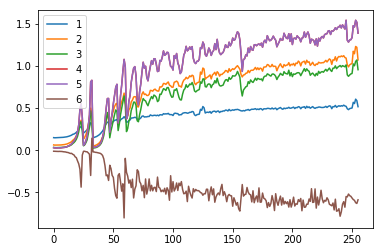

None


In [ ]:
let activationStatistics = learner.model.layerDelegates(havingType: ActivationStatistics.self)
for stats in activationStatistics {
    plt.plot(stats.activationMeans)
}
plt.legend(Array(1...activationStatistics.count))
plt.show()

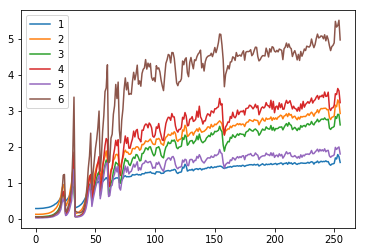

None


In [ ]:
for stats in activationStatistics {
    plt.plot(stats.activationStds)
}
plt.legend(Array(1...activationStatistics.count))
plt.show()

## Export

In [ ]:
notebookToScript(fname: (Path.cwd / "06_cuda.ipynb").string)